# Knowledge Distillation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import fastai
from fastai.vision import *

In [2]:
from fasterai.distillation import *

In [3]:
path = untar_data(URLs.IMAGENETTE_160)

In [4]:
bs, sz = 32, 160

In [5]:
data = (ImageList.from_folder(path).split_by_folder(valid='val')
                .label_from_folder().transform(([flip_lr(p=0.5)], []), size=sz)
                .databunch(bs=bs)
                .presize(sz, scale=(0.35,1))
                .normalize(imagenet_stats))

### Train the teacher first 

In [6]:
t_learner = Learner(data, models.xresnet18(pretrained=False, c_out=10), metrics=[accuracy])

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


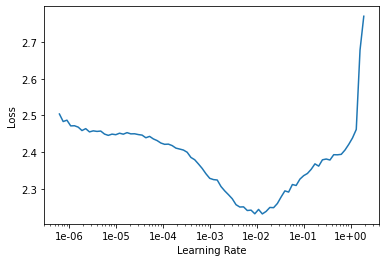

In [7]:
t_learner.lr_find()
t_learner.recorder.plot()

In [8]:
t_learner.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.520240,1.477678,0.516178,00:13
1,1.098915,0.984502,0.683312,00:14
2,0.921368,0.829569,0.734777,00:14


### Train the smaller network alone

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 10)     

    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = F.relu(F.max_pool2d(x, 2))
        x = self.bn2(self.conv2(x))
        x = F.relu(F.max_pool2d(x, 2))
        x = self.bn3(self.conv3(x))
        x = F.relu(F.max_pool2d(x, 2))
        x = self.pool(x)
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [10]:
s_learner = Learner(data, Net().cuda(), metrics=[accuracy])

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


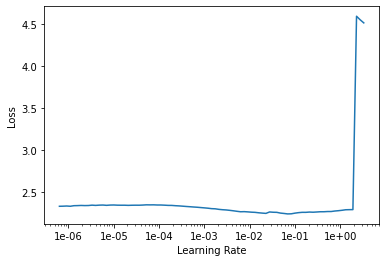

In [11]:
s_learner.lr_find()
s_learner.recorder.plot()

In [ ]:
s_learner.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.746937,1.683455,0.415032,00:07


### Now train the smaller model with distillation

In [ ]:
s_learner = Learner(data, Net().cuda(), metrics=[accuracy])

In [ ]:
s_learner.fit_one_cycle(3, 1e-3, callbacks=[KnowledgeDistillation(s_learner, teacher=t_learner)])